# **Варьирование параметров kernel_size**

In [1]:
import torch
import torch.nn.functional as F
import torchvision
import os
from torch import nn
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [2]:
transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ]
)

In [3]:
def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [4]:
seed_everything(42)

mnist_train = torchvision.datasets.MNIST(
    './mnist/',
    train=True,
    download=True,
    transform=transform
)

mnist_val = torchvision.datasets.MNIST(
    './mnist/',
    train=False,
    download=True,
    transform=transform
)

train_dataloader = torch.utils.data.DataLoader(mnist_train, batch_size=64, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(mnist_val, batch_size=64, shuffle=True)

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.59MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 133kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.26MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 12.4MB/s]


В качестве функции ошибки была принята torch.nn.funcional.NLLLoss()

In [6]:
def train(model, optimizer, n_epochs=5):
    history = {"val_loss" : [], "accuracy" : []}
    for epoch in range(n_epochs):

        # обучение
        for x_train, y_train in tqdm(train_dataloader):
            y_pred = model(x_train)
            loss = F.nll_loss(y_pred, y_train)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # валидация
        val_loss = []
        val_accuracy = []
        with torch.no_grad():
          for x_val, y_val in tqdm(val_dataloader):
            y_pred = model(x_val)
            loss = F.nll_loss(y_pred, y_val)
            val_loss.append(loss.numpy())
            val_accuracy.extend((torch.argmax(y_pred, dim=-1) == y_val).numpy().tolist())
        history["val_loss"].append(np.mean(val_loss))
        history["accuracy"].append(np.mean(val_accuracy))
        print(f'Epoch: {epoch}, loss: {np.mean(val_loss)}, accuracy: {np.mean(val_accuracy)}')
    return history

В качестве оптимизатора был принят torch.optim.Adam. Модель с таким оптимизатором давала точность ниже требуемого порога (0.9747), а при некоторых значениях kernel_size вовсе переобучалась, поэтому learning_rate был уменьшен до lr=0.001, что сразу позволило побить бейзлайн.

---

Параметр kernel_size варьировал для свертки и пуллинга, получилось что то по типу GridSearch.

In [7]:
results = {}
for conv_k in [2, 3, 4, 5, 6]:
  for pool_k in [2, 3, 4, 5, 6]:
    print(f"\n==Training with MaxPool2d(kernel_size={pool_k}) and Conv2d(kernel_size={conv_k})==")
    model = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=10, kernel_size=conv_k),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=pool_k),
        nn.Flatten(),
        nn.Linear(((28-conv_k+1)//pool_k)*((28-conv_k+1)//pool_k)*10, 128),
        nn.ReLU(),
        nn.Linear(128, 10),
        nn.LogSoftmax(dim=1)
    )
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    results[(conv_k, pool_k)] = train(model, optimizer, n_epochs=5)


==Training with MaxPool2d(kernel_size=2) and Conv2d(kernel_size=2)==


100%|██████████| 157/157 [00:02<00:00, 61.80it/s]


Epoch: 0, loss: 0.114882692694664, accuracy: 0.964


100%|██████████| 157/157 [00:02<00:00, 64.85it/s]


Epoch: 1, loss: 0.0731772929430008, accuracy: 0.9763


100%|██████████| 157/157 [00:02<00:00, 64.86it/s]


Epoch: 2, loss: 0.06080733239650726, accuracy: 0.9805


100%|██████████| 157/157 [00:02<00:00, 63.37it/s]


Epoch: 3, loss: 0.06448616087436676, accuracy: 0.9804


100%|██████████| 157/157 [00:02<00:00, 66.07it/s]


Epoch: 4, loss: 0.060943420976400375, accuracy: 0.9818

==Training with MaxPool2d(kernel_size=3) and Conv2d(kernel_size=2)==


100%|██████████| 157/157 [00:02<00:00, 52.81it/s]


Epoch: 0, loss: 0.13839192688465118, accuracy: 0.9581


100%|██████████| 157/157 [00:02<00:00, 68.67it/s]


Epoch: 1, loss: 0.09951932728290558, accuracy: 0.9692


100%|██████████| 157/157 [00:02<00:00, 69.30it/s]


Epoch: 2, loss: 0.07727382332086563, accuracy: 0.9747


100%|██████████| 157/157 [00:02<00:00, 69.39it/s]


Epoch: 3, loss: 0.07329962402582169, accuracy: 0.9774


100%|██████████| 157/157 [00:02<00:00, 53.22it/s]


Epoch: 4, loss: 0.0734059065580368, accuracy: 0.977

==Training with MaxPool2d(kernel_size=4) and Conv2d(kernel_size=2)==


100%|██████████| 157/157 [00:02<00:00, 71.24it/s]


Epoch: 0, loss: 0.1299905776977539, accuracy: 0.9597


100%|██████████| 157/157 [00:02<00:00, 68.06it/s]


Epoch: 1, loss: 0.09833186119794846, accuracy: 0.9685


100%|██████████| 157/157 [00:02<00:00, 59.92it/s]


Epoch: 2, loss: 0.07894165813922882, accuracy: 0.975


100%|██████████| 157/157 [00:02<00:00, 68.65it/s]


Epoch: 3, loss: 0.06709019839763641, accuracy: 0.978


100%|██████████| 157/157 [00:02<00:00, 70.95it/s]


Epoch: 4, loss: 0.06321927905082703, accuracy: 0.9797

==Training with MaxPool2d(kernel_size=5) and Conv2d(kernel_size=2)==


100%|██████████| 157/157 [00:02<00:00, 68.22it/s]


Epoch: 0, loss: 0.1510329246520996, accuracy: 0.9496


100%|██████████| 157/157 [00:02<00:00, 71.69it/s]


Epoch: 1, loss: 0.10852157324552536, accuracy: 0.964


100%|██████████| 157/157 [00:02<00:00, 63.31it/s]


Epoch: 2, loss: 0.09995333105325699, accuracy: 0.9674


100%|██████████| 157/157 [00:02<00:00, 73.14it/s]


Epoch: 3, loss: 0.08181360363960266, accuracy: 0.9716


100%|██████████| 157/157 [00:02<00:00, 69.70it/s]


Epoch: 4, loss: 0.07611902803182602, accuracy: 0.9744

==Training with MaxPool2d(kernel_size=6) and Conv2d(kernel_size=2)==


100%|██████████| 157/157 [00:02<00:00, 62.21it/s]


Epoch: 0, loss: 0.233567014336586, accuracy: 0.9288


100%|██████████| 157/157 [00:02<00:00, 73.18it/s]


Epoch: 1, loss: 0.15875042974948883, accuracy: 0.9517


100%|██████████| 157/157 [00:02<00:00, 60.88it/s]


Epoch: 2, loss: 0.14593647420406342, accuracy: 0.9546


100%|██████████| 157/157 [00:02<00:00, 72.76it/s]


Epoch: 3, loss: 0.13812315464019775, accuracy: 0.956


100%|██████████| 157/157 [00:02<00:00, 73.92it/s]


Epoch: 4, loss: 0.12534120678901672, accuracy: 0.9617

==Training with MaxPool2d(kernel_size=2) and Conv2d(kernel_size=3)==


100%|██████████| 157/157 [00:02<00:00, 64.83it/s]


Epoch: 0, loss: 0.09932918101549149, accuracy: 0.9692


100%|██████████| 157/157 [00:02<00:00, 66.05it/s]


Epoch: 1, loss: 0.06771927326917648, accuracy: 0.9768


100%|██████████| 157/157 [00:02<00:00, 64.94it/s]


Epoch: 2, loss: 0.06432797014713287, accuracy: 0.98


100%|██████████| 157/157 [00:02<00:00, 64.25it/s]


Epoch: 3, loss: 0.05213381350040436, accuracy: 0.9831


100%|██████████| 157/157 [00:02<00:00, 65.55it/s]


Epoch: 4, loss: 0.05530674383044243, accuracy: 0.9817

==Training with MaxPool2d(kernel_size=3) and Conv2d(kernel_size=3)==


100%|██████████| 157/157 [00:02<00:00, 52.91it/s]


Epoch: 0, loss: 0.08538616448640823, accuracy: 0.9732


100%|██████████| 157/157 [00:02<00:00, 68.56it/s]


Epoch: 1, loss: 0.06030845642089844, accuracy: 0.9802


100%|██████████| 157/157 [00:02<00:00, 67.33it/s]


Epoch: 2, loss: 0.05579015985131264, accuracy: 0.9819


100%|██████████| 157/157 [00:02<00:00, 68.95it/s]


Epoch: 3, loss: 0.0445421040058136, accuracy: 0.9849


100%|██████████| 157/157 [00:02<00:00, 55.91it/s]


Epoch: 4, loss: 0.04687163978815079, accuracy: 0.9863

==Training with MaxPool2d(kernel_size=4) and Conv2d(kernel_size=3)==


100%|██████████| 157/157 [00:02<00:00, 69.08it/s]


Epoch: 0, loss: 0.10037694126367569, accuracy: 0.9675


100%|██████████| 157/157 [00:02<00:00, 70.44it/s]


Epoch: 1, loss: 0.07287424802780151, accuracy: 0.9769


100%|██████████| 157/157 [00:02<00:00, 71.02it/s]


Epoch: 2, loss: 0.0533977746963501, accuracy: 0.9808


100%|██████████| 157/157 [00:02<00:00, 64.70it/s]


Epoch: 3, loss: 0.05583136901259422, accuracy: 0.9817


100%|██████████| 157/157 [00:02<00:00, 70.39it/s]


Epoch: 4, loss: 0.04633281007409096, accuracy: 0.9843

==Training with MaxPool2d(kernel_size=5) and Conv2d(kernel_size=3)==


100%|██████████| 157/157 [00:02<00:00, 71.48it/s]


Epoch: 0, loss: 0.12763887643814087, accuracy: 0.9592


100%|██████████| 157/157 [00:02<00:00, 56.79it/s]


Epoch: 1, loss: 0.09454534202814102, accuracy: 0.9696


100%|██████████| 157/157 [00:02<00:00, 67.80it/s]


Epoch: 2, loss: 0.07994101196527481, accuracy: 0.9738


100%|██████████| 157/157 [00:02<00:00, 69.71it/s]


Epoch: 3, loss: 0.06812278181314468, accuracy: 0.9774


100%|██████████| 157/157 [00:02<00:00, 57.27it/s]


Epoch: 4, loss: 0.059376947581768036, accuracy: 0.9806

==Training with MaxPool2d(kernel_size=6) and Conv2d(kernel_size=3)==


100%|██████████| 157/157 [00:02<00:00, 71.53it/s]


Epoch: 0, loss: 0.14812739193439484, accuracy: 0.9513


100%|██████████| 157/157 [00:02<00:00, 73.45it/s]


Epoch: 1, loss: 0.10017377883195877, accuracy: 0.9659


100%|██████████| 157/157 [00:02<00:00, 55.95it/s]


Epoch: 2, loss: 0.08028203248977661, accuracy: 0.9756


100%|██████████| 157/157 [00:02<00:00, 71.97it/s]


Epoch: 3, loss: 0.0747714713215828, accuracy: 0.9762


100%|██████████| 157/157 [00:02<00:00, 72.70it/s]


Epoch: 4, loss: 0.06934963166713715, accuracy: 0.9778

==Training with MaxPool2d(kernel_size=2) and Conv2d(kernel_size=4)==


100%|██████████| 157/157 [00:02<00:00, 65.69it/s]


Epoch: 0, loss: 0.07550396025180817, accuracy: 0.9755


100%|██████████| 157/157 [00:02<00:00, 65.78it/s]


Epoch: 1, loss: 0.05076446011662483, accuracy: 0.9822


100%|██████████| 157/157 [00:02<00:00, 66.62it/s]


Epoch: 2, loss: 0.04504188895225525, accuracy: 0.9859


100%|██████████| 157/157 [00:02<00:00, 65.93it/s]


Epoch: 3, loss: 0.038497742265462875, accuracy: 0.9872


100%|██████████| 157/157 [00:02<00:00, 66.64it/s]


Epoch: 4, loss: 0.043848760426044464, accuracy: 0.9861

==Training with MaxPool2d(kernel_size=3) and Conv2d(kernel_size=4)==


100%|██████████| 157/157 [00:02<00:00, 69.47it/s]


Epoch: 0, loss: 0.0793832316994667, accuracy: 0.9744


100%|██████████| 157/157 [00:02<00:00, 57.81it/s]


Epoch: 1, loss: 0.06905572861433029, accuracy: 0.9784


100%|██████████| 157/157 [00:02<00:00, 55.69it/s]


Epoch: 2, loss: 0.06619515269994736, accuracy: 0.9793


100%|██████████| 157/157 [00:02<00:00, 69.70it/s]


Epoch: 3, loss: 0.04296339303255081, accuracy: 0.9865


100%|██████████| 157/157 [00:02<00:00, 68.82it/s]


Epoch: 4, loss: 0.047758400440216064, accuracy: 0.9855

==Training with MaxPool2d(kernel_size=4) and Conv2d(kernel_size=4)==


100%|██████████| 157/157 [00:02<00:00, 68.92it/s]


Epoch: 0, loss: 0.07229793071746826, accuracy: 0.9775


100%|██████████| 157/157 [00:02<00:00, 71.73it/s]


Epoch: 1, loss: 0.06596033275127411, accuracy: 0.9778


100%|██████████| 157/157 [00:02<00:00, 64.63it/s]


Epoch: 2, loss: 0.05210474506020546, accuracy: 0.9828


100%|██████████| 157/157 [00:02<00:00, 72.76it/s]


Epoch: 3, loss: 0.04827755317091942, accuracy: 0.9841


100%|██████████| 157/157 [00:02<00:00, 70.71it/s]


Epoch: 4, loss: 0.04123162105679512, accuracy: 0.9873

==Training with MaxPool2d(kernel_size=5) and Conv2d(kernel_size=4)==


100%|██████████| 157/157 [00:02<00:00, 63.52it/s]


Epoch: 0, loss: 0.11664367467164993, accuracy: 0.9628


100%|██████████| 157/157 [00:02<00:00, 72.37it/s]


Epoch: 1, loss: 0.07152669131755829, accuracy: 0.9769


100%|██████████| 157/157 [00:02<00:00, 73.47it/s]


Epoch: 2, loss: 0.05433129519224167, accuracy: 0.9827


100%|██████████| 157/157 [00:02<00:00, 71.97it/s]


Epoch: 3, loss: 0.05584660917520523, accuracy: 0.9811


100%|██████████| 157/157 [00:03<00:00, 52.07it/s]


Epoch: 4, loss: 0.058663319796323776, accuracy: 0.9827

==Training with MaxPool2d(kernel_size=6) and Conv2d(kernel_size=4)==


100%|██████████| 157/157 [00:02<00:00, 72.25it/s]


Epoch: 0, loss: 0.11944277584552765, accuracy: 0.9624


100%|██████████| 157/157 [00:02<00:00, 62.36it/s]


Epoch: 1, loss: 0.08219720423221588, accuracy: 0.9728


100%|██████████| 157/157 [00:02<00:00, 68.03it/s]


Epoch: 2, loss: 0.07227183133363724, accuracy: 0.9773


100%|██████████| 157/157 [00:02<00:00, 65.23it/s]


Epoch: 3, loss: 0.0588216707110405, accuracy: 0.9811


100%|██████████| 157/157 [00:02<00:00, 58.11it/s]


Epoch: 4, loss: 0.0548788420855999, accuracy: 0.9815

==Training with MaxPool2d(kernel_size=2) and Conv2d(kernel_size=5)==


100%|██████████| 157/157 [00:02<00:00, 63.71it/s]


Epoch: 0, loss: 0.06822311133146286, accuracy: 0.9779


100%|██████████| 157/157 [00:02<00:00, 63.21it/s]


Epoch: 1, loss: 0.04534529894590378, accuracy: 0.9836


100%|██████████| 157/157 [00:02<00:00, 64.71it/s]


Epoch: 2, loss: 0.052488066256046295, accuracy: 0.9833


100%|██████████| 157/157 [00:02<00:00, 65.01it/s]


Epoch: 3, loss: 0.042709216475486755, accuracy: 0.9862


100%|██████████| 157/157 [00:02<00:00, 65.32it/s]


Epoch: 4, loss: 0.057284165173769, accuracy: 0.9828

==Training with MaxPool2d(kernel_size=3) and Conv2d(kernel_size=5)==


100%|██████████| 157/157 [00:02<00:00, 68.81it/s]


Epoch: 0, loss: 0.07614736258983612, accuracy: 0.9749


100%|██████████| 157/157 [00:02<00:00, 67.23it/s]


Epoch: 1, loss: 0.05942755192518234, accuracy: 0.9804


100%|██████████| 157/157 [00:02<00:00, 67.32it/s]


Epoch: 2, loss: 0.043041471391916275, accuracy: 0.9854


100%|██████████| 157/157 [00:02<00:00, 68.14it/s]


Epoch: 3, loss: 0.05066332966089249, accuracy: 0.983


100%|██████████| 157/157 [00:02<00:00, 69.01it/s]


Epoch: 4, loss: 0.039702724665403366, accuracy: 0.987

==Training with MaxPool2d(kernel_size=4) and Conv2d(kernel_size=5)==


100%|██████████| 157/157 [00:02<00:00, 60.41it/s]


Epoch: 0, loss: 0.08343655616044998, accuracy: 0.9722


100%|██████████| 157/157 [00:03<00:00, 52.14it/s]


Epoch: 1, loss: 0.062348078936338425, accuracy: 0.9787


100%|██████████| 157/157 [00:02<00:00, 68.80it/s]


Epoch: 2, loss: 0.040416568517684937, accuracy: 0.986


100%|██████████| 157/157 [00:02<00:00, 69.14it/s]


Epoch: 3, loss: 0.04482000321149826, accuracy: 0.9842


100%|██████████| 157/157 [00:02<00:00, 70.87it/s]


Epoch: 4, loss: 0.04571480676531792, accuracy: 0.9856

==Training with MaxPool2d(kernel_size=5) and Conv2d(kernel_size=5)==


100%|██████████| 157/157 [00:02<00:00, 70.75it/s]


Epoch: 0, loss: 0.09312989562749863, accuracy: 0.9733


100%|██████████| 157/157 [00:02<00:00, 74.20it/s]


Epoch: 1, loss: 0.07682310789823532, accuracy: 0.9767


100%|██████████| 157/157 [00:02<00:00, 62.14it/s]


Epoch: 2, loss: 0.07690928131341934, accuracy: 0.9744


100%|██████████| 157/157 [00:02<00:00, 73.47it/s]


Epoch: 3, loss: 0.07446569949388504, accuracy: 0.9749


100%|██████████| 157/157 [00:02<00:00, 75.00it/s]


Epoch: 4, loss: 0.057556718587875366, accuracy: 0.9815

==Training with MaxPool2d(kernel_size=6) and Conv2d(kernel_size=5)==


100%|██████████| 157/157 [00:02<00:00, 70.39it/s]


Epoch: 0, loss: 0.08078667521476746, accuracy: 0.9748


100%|██████████| 157/157 [00:02<00:00, 55.48it/s]


Epoch: 1, loss: 0.07343500107526779, accuracy: 0.9756


100%|██████████| 157/157 [00:02<00:00, 74.28it/s]


Epoch: 2, loss: 0.05723249912261963, accuracy: 0.9813


100%|██████████| 157/157 [00:02<00:00, 72.57it/s]


Epoch: 3, loss: 0.046659477055072784, accuracy: 0.984


100%|██████████| 157/157 [00:02<00:00, 72.43it/s]


Epoch: 4, loss: 0.05015835911035538, accuracy: 0.9836

==Training with MaxPool2d(kernel_size=2) and Conv2d(kernel_size=6)==


100%|██████████| 157/157 [00:02<00:00, 67.76it/s]


Epoch: 0, loss: 0.07135070860385895, accuracy: 0.9767


100%|██████████| 157/157 [00:02<00:00, 68.07it/s]


Epoch: 1, loss: 0.052601590752601624, accuracy: 0.9817


100%|██████████| 157/157 [00:02<00:00, 68.13it/s]


Epoch: 2, loss: 0.045834172517061234, accuracy: 0.985


100%|██████████| 157/157 [00:02<00:00, 68.14it/s]


Epoch: 3, loss: 0.034851495176553726, accuracy: 0.9892


100%|██████████| 157/157 [00:02<00:00, 67.25it/s]


Epoch: 4, loss: 0.036647263914346695, accuracy: 0.9879

==Training with MaxPool2d(kernel_size=3) and Conv2d(kernel_size=6)==


100%|██████████| 157/157 [00:02<00:00, 71.12it/s]


Epoch: 0, loss: 0.06736886501312256, accuracy: 0.9769


100%|██████████| 157/157 [00:02<00:00, 69.71it/s]


Epoch: 1, loss: 0.05197441950440407, accuracy: 0.982


100%|██████████| 157/157 [00:02<00:00, 69.96it/s]


Epoch: 2, loss: 0.04147118330001831, accuracy: 0.986


100%|██████████| 157/157 [00:02<00:00, 70.47it/s]


Epoch: 3, loss: 0.036203403025865555, accuracy: 0.9875


100%|██████████| 157/157 [00:02<00:00, 70.27it/s]


Epoch: 4, loss: 0.036582380533218384, accuracy: 0.9882

==Training with MaxPool2d(kernel_size=4) and Conv2d(kernel_size=6)==


100%|██████████| 157/157 [00:02<00:00, 70.57it/s]


Epoch: 0, loss: 0.08437046408653259, accuracy: 0.9734


100%|██████████| 157/157 [00:02<00:00, 62.80it/s]


Epoch: 1, loss: 0.061797332018613815, accuracy: 0.9806


100%|██████████| 157/157 [00:02<00:00, 53.29it/s]


Epoch: 2, loss: 0.04991495981812477, accuracy: 0.9836


100%|██████████| 157/157 [00:02<00:00, 67.74it/s]


Epoch: 3, loss: 0.04794891178607941, accuracy: 0.9834


100%|██████████| 157/157 [00:02<00:00, 72.98it/s]


Epoch: 4, loss: 0.04513634741306305, accuracy: 0.9859

==Training with MaxPool2d(kernel_size=5) and Conv2d(kernel_size=6)==


100%|██████████| 157/157 [00:02<00:00, 73.75it/s]


Epoch: 0, loss: 0.08937069028615952, accuracy: 0.9718


100%|██████████| 157/157 [00:02<00:00, 73.57it/s]


Epoch: 1, loss: 0.06293949484825134, accuracy: 0.9799


100%|██████████| 157/157 [00:02<00:00, 73.10it/s]


Epoch: 2, loss: 0.0648367702960968, accuracy: 0.9788


100%|██████████| 157/157 [00:02<00:00, 67.75it/s]


Epoch: 3, loss: 0.0521920807659626, accuracy: 0.9832


100%|██████████| 157/157 [00:02<00:00, 54.92it/s]


Epoch: 4, loss: 0.049520693719387054, accuracy: 0.9844

==Training with MaxPool2d(kernel_size=6) and Conv2d(kernel_size=6)==


100%|██████████| 157/157 [00:02<00:00, 73.97it/s]


Epoch: 0, loss: 0.11184200644493103, accuracy: 0.9651


100%|██████████| 157/157 [00:02<00:00, 72.63it/s]


Epoch: 1, loss: 0.10457538068294525, accuracy: 0.9678


100%|██████████| 157/157 [00:02<00:00, 73.17it/s]


Epoch: 2, loss: 0.07784296572208405, accuracy: 0.9768


100%|██████████| 157/157 [00:02<00:00, 74.02it/s]


Epoch: 3, loss: 0.0686529204249382, accuracy: 0.978


100%|██████████| 157/157 [00:02<00:00, 59.25it/s]

Epoch: 4, loss: 0.06380660831928253, accuracy: 0.9799


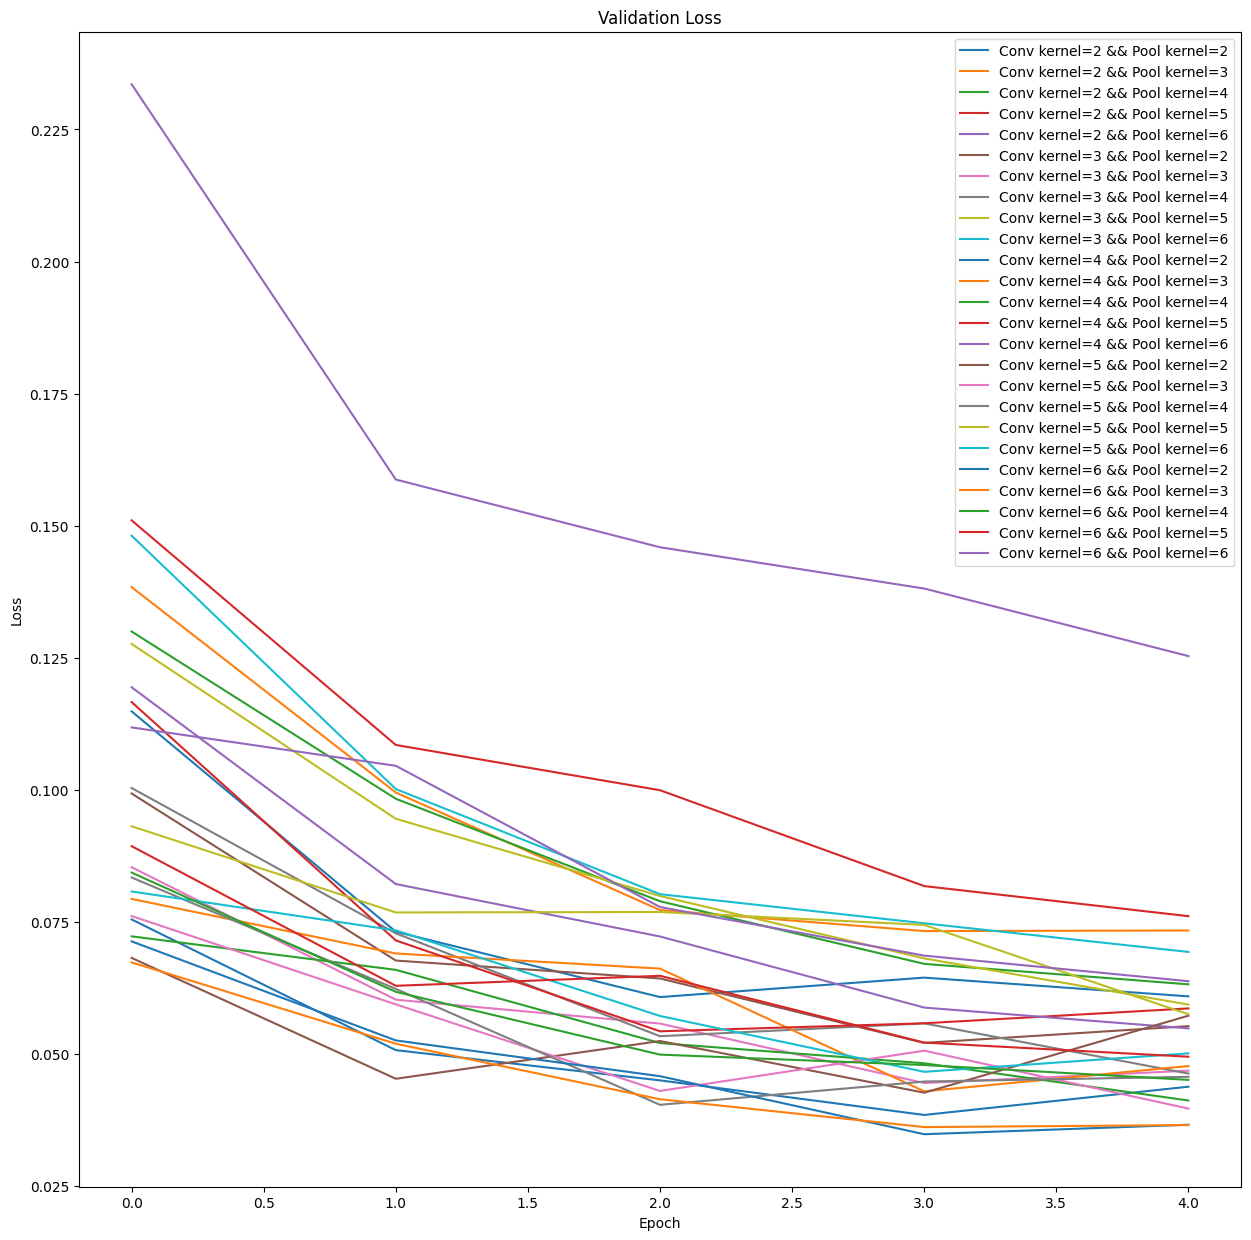

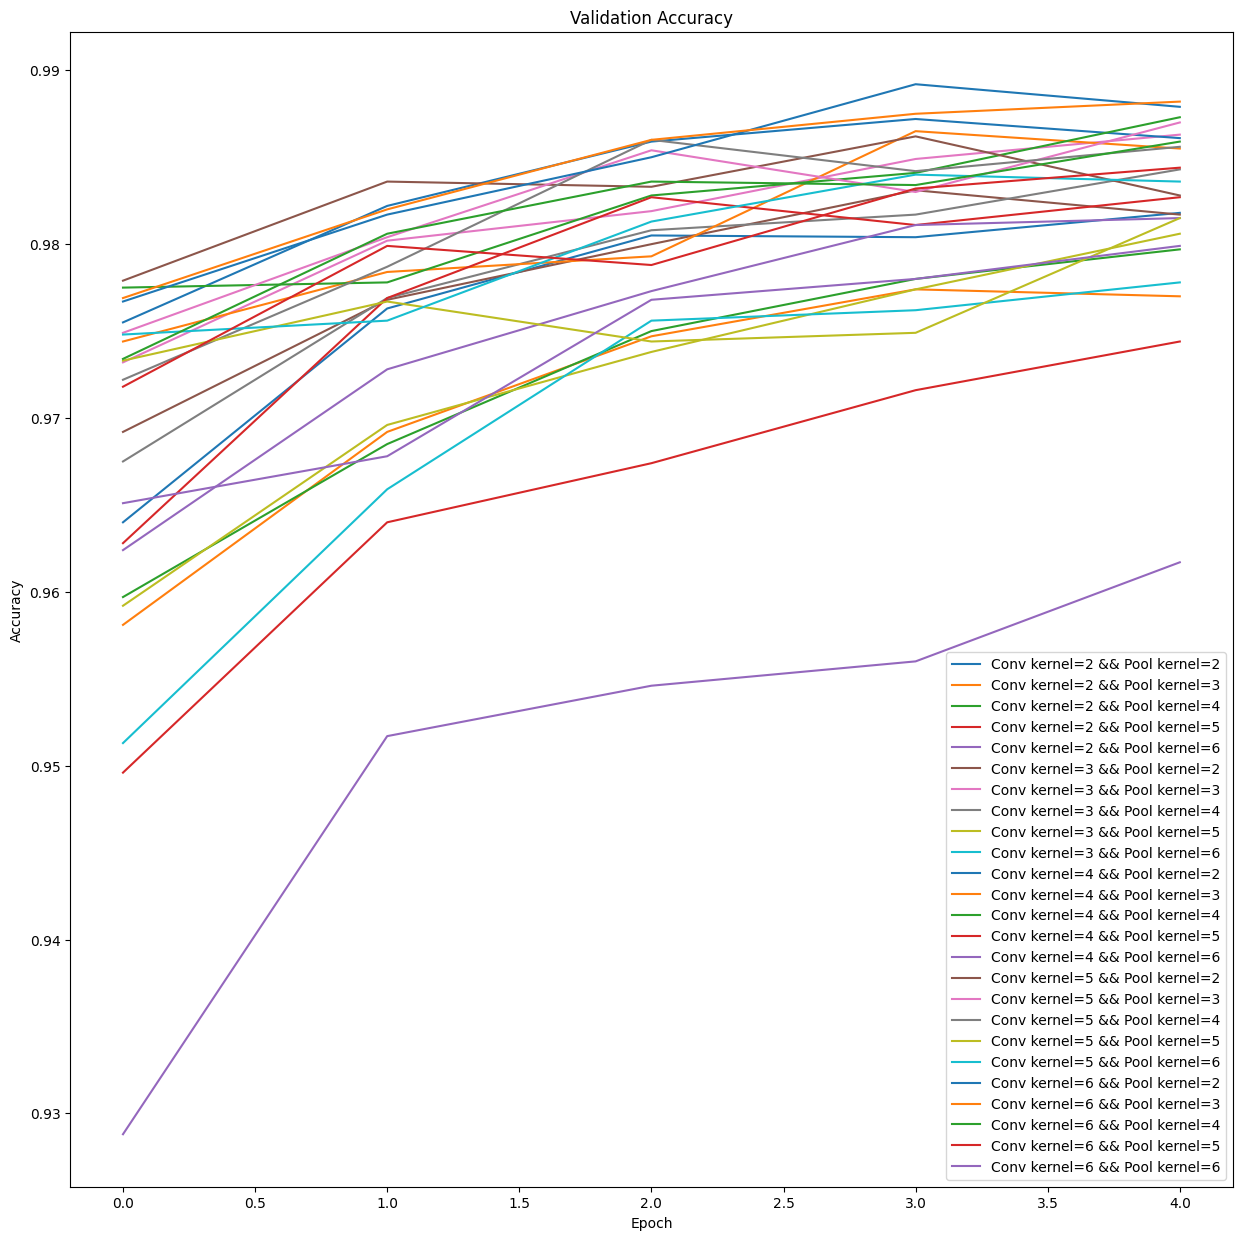

In [12]:
plt.figure(figsize=(15, 15))
for(conv_k, pool_k), hist in results.items():
    plt.plot(hist["val_loss"], label=f"Conv kernel={conv_k} && Pool kernel={pool_k}")
plt.title("Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(15, 15))
for (conv_k, pool_k), hist in results.items():
    plt.plot(hist["accuracy"], label=f"Conv kernel={conv_k} && Pool kernel={pool_k}")
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

***Итого:***


*   MAX(accuracy) = **0.9882** при Conv2d(kernel_size=**6**) && MaxPool2d(kernel_size=**3**)
*  MIN(accuracy) = **0.9617** при Conv2d(kernel_size=**2**) && MaxPool2d(kernel_size=**6**)
